# Minimi quadrati

Il coefficiente di correlazione misura la forza e segno di una relazione tra due variabili in una relazione, ma non la pendenza. Ci sono molti modi per determinare la pendenza, il più comune è il **metodo dei minimi quadrati**.

Una "regressione lineare" è una linea che modella una regressione tra due variabili mentre i minimi quadrati sono un metodo per minimizzare l'errore quadratico medio MSE tra la linea e i dati.

Supponiamo di avere una sequenza di punti `ys` che vogliamo esprimere come funzione di un'altra sequenza di punti `xs`. Se esiste una relazione lineare tra xs e ys con la pendenza `slope` e intercetta `inter` ci aspetteremo che ogni punto i rispetti la seguente equazione:

`y[i] = inter + slope * x[i]`

Quasi sicuramente non saremo di fronte ad una relazione perfetta, perciò le nostre previsioni saranno approssimate con un certo errore chiamato anche **residuale**

`res = ys - (inter + slope * sx)`

I residuali potrebbero essere dovuti a fattori randomici come errori di misura o fattori deterministici non conosciuti.
Facciamo un esempio, se volessimo predirre il peso in funzione dell'altezza i fattori non conosciuti potrebbero essere la dieta, l'esercizio fisico e la corporatura.

Se utilizziamo dei parametri `inter` e `slope` non corretti i residuali avranno un valore grande al contrario più ci si avvicina alla soluzione più questi diminuiranno verso il minimo possibile.

Si potrebbe provare a minimizzare il valore assoluto dei residuali, il loro quadrato o il loro cubo, la scelta più frequente è quella di minimizzare la somma del quadrato dei residuali:

`sum(res**2)`

Ma perchè?
* Elevare al quadrato i residuali permette di trattare i valori negativi e positivi allo stesso modo, che rappresenta quello che vorremmo fare.
* Elevare al quadrato i residuali permette da importanza ai residuali più grandi
* Se i residuali non sono correlati e sono normalmente distribuiti con media 0 e varianza sconosciuta, allora i minimi quadrati  sono anche il migliore stimatore di `inter` e `slope` 
* i valori di `inter` e `slope`  che minimizzano i minimi quadrati possono essere calcolati in modo efficiente.

Di seguito il codice per il calcolo dei minimi quadrati, per una spieagazione sul funzionamento si consiglia di visualizzare la pagina di [wikipedia](https://en.wikipedia.org/wiki/Numerical_methods_for_linear_least_squares).


In [1]:
import numpy as np


def cov(xs, ys, meanx=None, meany=None):
    """Computes cov(X, Y).

    Args:
        xs: sequence of values
        ys: sequence of values
        meanx: optional float mean of xs
        meany: optional float mean of ys

    Returns:
        Cov(X, Y)
    """
    xs = np.asarray(xs)
    ys = np.asarray(ys)

    if meanx is None:
        meanx = np.mean(xs)
    if meany is None:
        meany = np.mean(ys)

    cov = np.dot(xs-meanx, ys-meany) / len(xs)
    return cov


def leastSquare(xs,ys):
    xs = np.array(xs)
    ys = np.array(ys)
    
    meanx = xs.mean()
    varx = xs.var()
    
    meany = ys.mean()
    
    slope = cov(xs, ys, meanx, meany) / varx
    inter = meany - slope * meanx
    
    return inter,slope

`leastSquare` accetta in ingresso `xs` e `ys` e restituisce i parametri stimati.
Possiamo costruire anche la funzione `fitLine` che prende i parametri `inter` e `slope` e crea la linea dalla sequenza dei valori `xs`.

In [2]:
def fitLine(xs,inter,slope):
    fit_xs = np.sort(xs)
    fit_ys = inter + (slope * fit_xs)
    
    return fit_xs,fit_ys

proviamo ad utilizzare questa funzione per creare una funzione per calcolare i minimi quadrati al peso del nascituro in funzione dell'età della madre.

In [3]:
from utils import readReadFemPreg

preg = readReadFemPreg()
live = preg[preg.outcome == 1]

live = live.dropna(subset=['agepreg','totalwgt_lb'])

ages = live.agepreg
weights = live.totalwgt_lb

inter, slope = leastSquare(ages,weights)
fit_xs, fit_ys = fitLine(ages, inter, slope)

Text(0, 0.5, 'birth weight (lbs)')

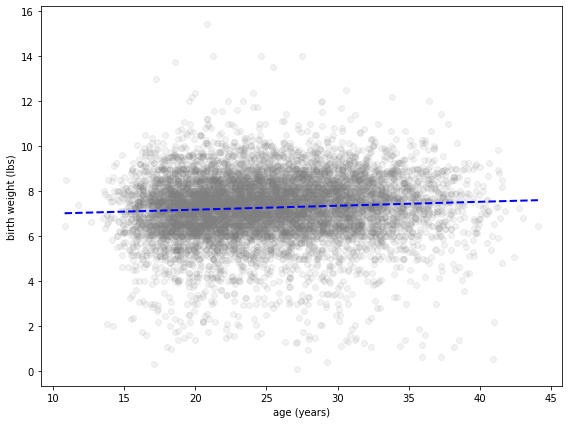

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt


plt.figure(figsize=(8,6), tight_layout=True)
plt.scatter(ages, weights, color='gray', alpha=0.1)
plt.plot(fit_xs, fit_ys,'--b',linewidth=2)
plt.xlabel("age (years)")
plt.ylabel("birth weight (lbs)")

In [5]:
print("slope {0:.2f} intercept {1:.2f}".format(slope,inter))

slope 0.02 intercept 6.83


I valori di pendenza e intercettazione sono rispettivamente 6.83 lbs e 0.02 lbs. Detto così però i valori hanno poco significato. 

* intercept rappresenta il peso aspettato se la madre avesse 0 anni e questo non ha nessun senso
* la pendenza ha un valore piccolo e non è facile trattarlo facilmente

Invece di rappresentare il valore di intercept a $x=0$, è spesso utile rappresentarlo come media di x.
In questo esempio avremmo che la media delle età è di circa 25 anni e il peso medio dei bebè a 25 anni è di 7.3 pounds.

# I residuali

Un ulteriore test è quello di stampare i residuali, mostriamo una funzione per stampare i residuali:

In [6]:
def residuals(xs, ys, inter, slope):
    """
    Calcola i residuali per una regressione lineare con i parametri inter e slope
    
    Args:
        xs: variabile indipendente
        ys: variabile dipendente
        inter: float intercept
        slope: float slope

    Returns:
        lista dei residuali
    """
    xs = np.asarray(xs)
    ys = np.asarray(ys)
    res = ys - (inter + slope * xs)
    return res

la funzione `residuals`ottiene in ingresso `xs` e `ys` e le stime dei parametri `inter` e `slope`, il risultato è la differenza tra i valori attuali e i valori previsti dalla regressione.

Per visualizzare i residuali, si raggruppano per età e si calcolano i percentili per ogni gruppo come fatto in precedenza, qui sotto viene mostrato il 25°, il 50° e il 75° percentile dei residuali per ogni gruppo.

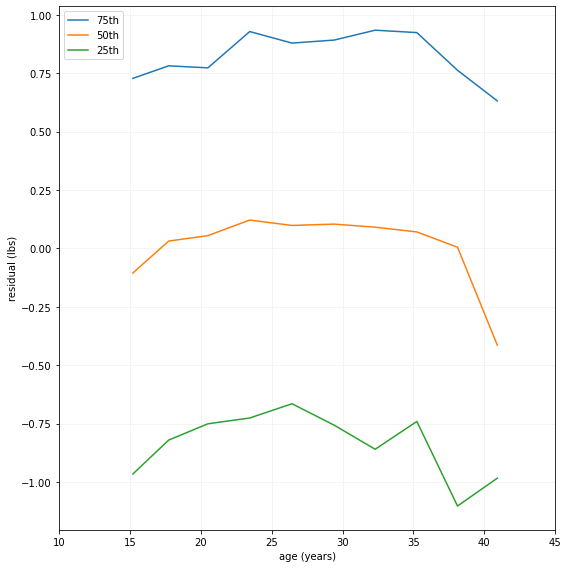

In [7]:
from utils import calcCdf,percentile
live['residual'] = residuals(ages, weights, inter, slope)

bins = np.arange(10, 48, 3)
indices = np.digitize(live.agepreg, bins)
groups = live.groupby(indices)

aPlot = [group.agepreg.mean() for _, group in groups][1:-1]
cdfs = [calcCdf(group.residual) for _, group in groups][1:-1]

plt.figure(figsize=(8,8), tight_layout=True)

for percent in [75, 50, 25]:
    wPlot = [percentile(cdf[0],cdf[2],percent / 100) for cdf in cdfs]
    label = '%dth' % percent
    plt.plot(aPlot, wPlot, label=label)

    
plt.xlabel("age (years)")
plt.ylabel("residual (lbs)")
plt.xlim([10, 45])
plt.grid(color='0.95')
plt.legend(loc='upper left')


La mediana ha valore vicino allo zero, come ci si può aspettare e il range degli interquartili si aggira sui 2 pounds.

Dunque se si conosce l'età della madre potremmo poter stimare il peso del bebè con un range di errore pari ad un pound circa il 50% delle volte.

Idealmente queste linee dovrebbero essere piatte indicando che i residuali siano randomici e paralleli indicando che la varianza dei residuali è la stessa per tutti i gruppi di età. Le linee sono quasi parallele il che è un bene, abbiamo comunque delle curvature il che indica che le relazioni non sono propriamente lineari.

Tuttavia la regressione lineare potrebbe essere un modello troppo semplice per alcuni scopi.

## Stima

I parametri `slope` e  `inter` sono stime basate su campione, come tutte le altre stime sono vulnerabili alla distorsine del campionamento, errori di misura e errori di campionamento.

Come già discusso, la distorsine del campionamento è causata da un campionamento non rappresentativo, l'errore di misura è causato da errori nella raccolta dei dati e l'errore del campionamento è il risultato di una misura basata su un campione invece che sulla intera popolazione.

Per valutare l'errore di campionamento possiamo domandarci "se eseguissimo ancora l'esperimento quanta variabilità potremmo aspettarci nelle stime ?" Possiamo rispondere alla domanda eseguendo la simulazione degli esperimenti e calcolando la distribuzione campionaria delle stime.

Simuliamo l'esperimento ricampionando i dati, trattiamo le osservazioni delle gestazioni come se fossero l'intera popolazione e preleviamo dei campioni con ripetizione dal campione osservato.

In [8]:
def sampleRows(df, nrows, replace=False):
    """
    Scelgo un campione di righe da un dataframe

    df: DataFrame
    nrows: numero di righe
    replace: indica se usare la ripetione o meno

    returns: DataFrame
    """
    indices = np.random.choice(df.index, nrows, replace=replace)
    sample = df.loc[indices]
    return sample


def samplingDistributions(live, iters=101):
    """Estimates sampling distributions by resampling rows.

    live: DataFrame
    iters: number of times to run simulations

    returns: pair of sequences (inters, slopes)
    """
    t = []
    for _ in range(iters):
        sample = sampleRows(live,len(live),replace = True)
        ages = sample.agepreg
        weights = sample.totalwgt_lb
        estimates = leastSquare(ages, weights)
        t.append(estimates)

    inters, slopes = zip(*t)
    return inters, slopes


La funzione `samplingDistributions` prende il dataframe con una riga per nascita e `iters` che rappresenta il numero di esperimenti da simulare. Usiamo la funzione `sampleRows` per ricampionare le gestazioni osservate.

Dopo il ricampionamento usiamo i campioni simulati per stimare i parametri. Il risultato è due sequenze, le stime dei valori `slope` e  `inter`.

Creiamo il riassunto delle del campione delle distribuzioni stampando lo standard error e l'intervallo di confidenza.

In [9]:
import math
from utils import confidenceInterval

def std(xs, mu=None, ddof=0):
    """
    calcolo la deviazione standard

    xs: sequenza di valori
    mu: parametro opzionale media conosciuta
    ddof: gradi di libertà

    returns: float
    """
    xs = np.asarray(xs)

    if mu is None:
        mu = xs.mean()

    ds = xs - mu
    return math.sqrt(np.dot(ds, ds) / (len(xs) - ddof))


def summarize(estimates, actual=None):
    """
    visualizzo lo standard error e il 90% dell'intervallo di confidenza

    estimates: sequenza di stime
    actual: float media attuale
    """
    mean = np.mean(estimates)
    stderr = std(estimates, mu=actual)
    unique, pmf, cdf = calcCdf(estimates)
    ci = confidenceInterval(unique,cdf,0.9)
    print('mean {0:.2f} \n SE {1:.2f} \n CI min {2:.2f} CI max {3:.2f}'.format(mean, stderr, ci[0], ci[1]))

come scritto nel commento la funzione summarize prende le stime visualizza lo standard error e il 90% dell'intervallo di confidenza.



In [10]:
inters, slopes = samplingDistributions(live, iters=1001)

In [11]:
ages = live.agepreg
weights = live.totalwgt_lb
inter, slope = leastSquare(ages, weights)

summarize(inters, inter)

mean 6.83 
 SE 0.07 
 CI min 6.72 CI max 6.95


In [12]:
summarize(slopes, slope)

mean 0.02 
 SE 0.00 
 CI min 0.01 CI max 0.02


C'è quasi un fattore 2 tra l'intervallo di confidenza di questo parametro (pendenza), consideriamo dunque questa una stima approssimativa.

Per visualizzare l'errore di campionamento della stima possiamo visualizzare tutti le linee della regressione lineare oppure con una rappresentazione meno disordinata, mostriamo il 90% dell'intervallo di confidenza di ogni età.

Qui il codice

In [13]:
def percentileRow(array, p):
    """
    Selects the row from a sorted array that maps to percentile p.

    p: float 0 100

    returns: NumPy array (one row)
    """
    rows, cols = array.shape
    index = int(rows * p / 100)
    return array[index,]


def percentileRows(ys_seq, percents):
    """
    Given a collection of lines, selects percentiles along vertical axis.

    For example, if ys_seq contains simulation results like ys as a
    function of time, and percents contains (5, 95), the result would
    be a 90% CI for each vertical slice of the simulation results.

    ys_seq: sequence of lines (y values)
    percents: list of percentiles (0-100) to select

    returns: list of NumPy arrays, one for each percentile
    """
    
    nrows = len(ys_seq)
    ncols = len(ys_seq[0])
    array = np.zeros((nrows, ncols))

    for i, ys in enumerate(ys_seq):
        array[i,] = ys

    array = np.sort(array, axis=0)
    
    rows = [percentileRow(array, p) for p in percents]
    return rows

def plotConfidenceIntervals(xs, inters, slopes, res=None, percent=90,**option):
    """
    Plots the 90% confidence intervals for weights based on ages.

    xs: sequence
    inters: estimated intercepts
    slopes: estimated slopes
    res: residuals
    percent: what percentile range to show
    """
    fys_seq = []
    for inter, slope in zip(inters, slopes):
        fxs, fys = fitLine(xs, inter, slope)
        if res is not None:
            fys += np.random.permutation(res)
        fys_seq.append(fys)

    p = (100 - percent) / 2
    percents = p, 100 - p
    
    low, high = percentileRows(fys_seq, percents)
    plt.fill_between(fxs, low, high,**option)

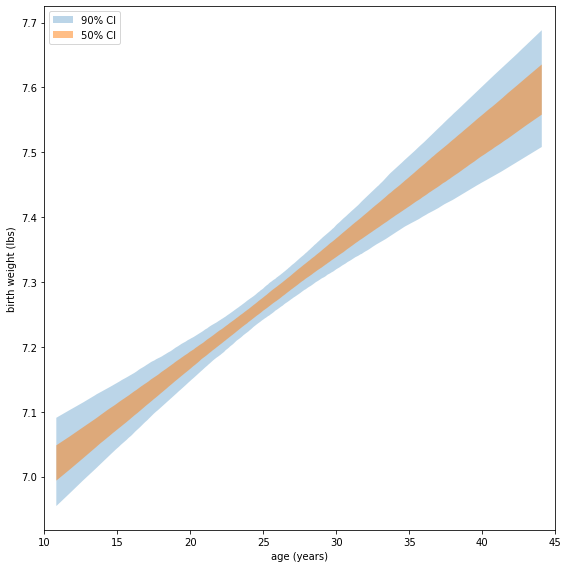

In [14]:
plt.figure(figsize=(8,8), tight_layout=True)

plotConfidenceIntervals(ages, inters, slopes, percent=90, alpha=0.3, label='90% CI')
plotConfidenceIntervals(ages, inters, slopes, percent=50,alpha=0.5, label='50% CI')

plt.xlabel("age (years)")
plt.ylabel("birth weight (lbs)")
plt.xlim([10, 45])
plt.legend(loc='upper left')

`xs` è la sequenza delle età delle mamme, `inter` e `slopes` sono le stime dei parametri generate dalla funzione `samplingDistributions`.

La funzione `plotConfidenceIntervals` genera una linea per ogni coppia `inter` e `slopes` e salva il risultato nella sequenza `fys_seq`. Viene poi usata `percentileRows` per selezionare il percentile superiore e inferiore y per ogni valore x. Questi valori vengono poi passati alla funzione `fill_between` di mathplotlib che disegna un poligono che riempie lo spazio tra le due linee.

Notiamo che il grafico mostra la larghezza delle regioni rappresentate l'effetto dell'errore di campionamento, l'effetto è più piccolo per i valori vicino alla media e più largo agli estremi.

## bontà del modello

Ci sono molti modi per misurare la qualità di un modello lineare. Uno fra i più semplici è la deviazione standard dei residuali.

Se usiamo un modello lineare per fare delle previsioni, `Std(res)` è la radice quadrata della media quadratica (root mean squared) RMSE delle nostre previsioni.

Un altro modo per misurare la bontà della regressione è il **coefficiente di determinazione** scritto come $R^2$. 

In [15]:
def var(xs, mu=None, ddof=0):
    xs = np.asarray(xs)

    if mu is None:
        mu = xs.mean()

    ds = xs - mu
    return np.dot(ds, ds) / (len(xs) - ddof)

def coefDetermination(ys, res):
    return 1 - var(res) / var(ys)

`var(res)` rappresenta l'MSE delle nostre previsioni del modello,  `var(ys)` in invece rappresenta l'MSE del nostro dato.
Quindi il loro rapporto è la frazione di MSE che rimane se usiamo il modello e $R^2$ è la frazione di MSE eliminata dal modello.

## Ricampionamento ponderato

Abbiamo sempre trattato il dataset NSFG come come un campione significativo, ma come menzionato dal gruppo che ha creato il dataset questo non è vero.

Il sondaggio ha sovracampionato deliberatamente alcuni gruppi per cercare di avere la possibilità di ottenere dei dati statisticamente significativi.

Questo sondaggio è molto utile per molti scopi significa anche che non si può utilizzare il campione per stimare dei valori per la popolazione in generale senza trattare il processo di campionamento.

Per ogni persona il dataset NSFG include una variabile `finalwgt` che rappresenta il numero di persone della popolazione in generale che il soggetto rappresenta. Questo valore viene anche chiamato **peso di campionamento** sampling weight o solamente peso.

Come esempio se in un sondaggio rispondono 100.000 persone in un paese di 300 milioni ogni persona del campione rappresenta 3000 persone. Se sovracampioniamo un gruppo di un fattore di 2 ogni persona di quel gruppo avrà un peso minore in quanto rappresenterà 1500 persone.

Per correggere il dataset dal problema di oversampling possiamo ricampionare il dataset. Possiamo trarre campioni dal sondaggio usando le probabilità proporzionali al peso di campionamento.

Poi per ogni quantità che vogliamo stimare possiamo generare la distribuzione di campionamento lo standard error e l'intervallo di confidenza.

Abbiamo visto prima la funzione `resampleRows` che sceglie le righe da un DataFrame dando ad ognuna la stessa probabilità.
Ora dobbiamo fare la stessa cosa usando la probabilità proporzionale al peso.

In [20]:
def resampleRows(df, replace=False):
    indices = np.random.choice(df.index, len(df), replace=True)
    sample = df.loc[indices]
    return sample


def resampleRowsWeighted(df, column='finalwgt'):
    weights = df[column].copy()
    weights /= sum(weights)
    indices = np.random.choice(df.index, len(df), replace=True, p=weights)
    sample = df.loc[indices]
    return sample

In [22]:
iters = 1000

mean = live.totalwgt_lb.mean()
print('mean {0:.2f}'.format(mean))

estimates = [resampleRowsWeighted(live).totalwgt_lb.mean() for _ in range(iters)]
summarize(estimates)

estimates = [resampleRows(live).totalwgt_lb.mean() for _ in range(iters)]
summarize(estimates)

mean 7.27
mean 7.35 
 SE 0.01 
 CI min 7.32 CI max 7.37
mean 7.27 
 SE 0.01 
 CI min 7.24 CI max 7.29


Vediamo che l'uso dei pesi è piccolo ma non trascurabile.